In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
torch.manual_seed(42)

# Generate toy dataset
X, y = make_moons(n_samples=1_000, noise=0.1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define differnt weight initialization methods
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, generator=torch.manual_seed(2))
        nn.init.zeros_(m.bias)

def init_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

def init_weights_orthogonal(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight, generator=torch.manual_seed(42))
        nn.init.zeros_(m.bias)

# Define the custom MLP model with 8 layers and final linear classifier
class DeepTanhMLP(nn.Module):
    def __init__(self, depth=8):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(nn.Linear(2, 2))  # each layer is 2x2
        self.final = nn.Linear(2, 2)  # classifier output (2 classes)

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return self.final(x)

    def transform(self, x, layer_index):
        """Transform data up to a specific layer (for visualization)"""
        for i in range(layer_index):
            x = torch.tanh(self.layers[i](x))
        return x.detach().numpy()

def train_model(model, X_train, y_train, criterion, optimizer, epochs=1000):
    losses = []
    accuracies = []
    for epoch in range(1000):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            pred = model(X_test).argmax(dim=1)
            logits = model(X_test)
            acc = (pred == y_test).float().mean().item()
            loss_val = criterion(logits, y_test).item()

            losses.append(loss_val)
            accuracies.append(acc)            

    # Accuracy check
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test).float().mean().item()
    print(f"Test Accuracy: {acc:.2%}")

    return losses, accuracies

def plot_losses_accuracies(losses, accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(losses, label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Test Loss over Epochs')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(accuracies, label='Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Test Accuracy over Epochs')
    axs[1].grid()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

Test Accuracy: 48.00%


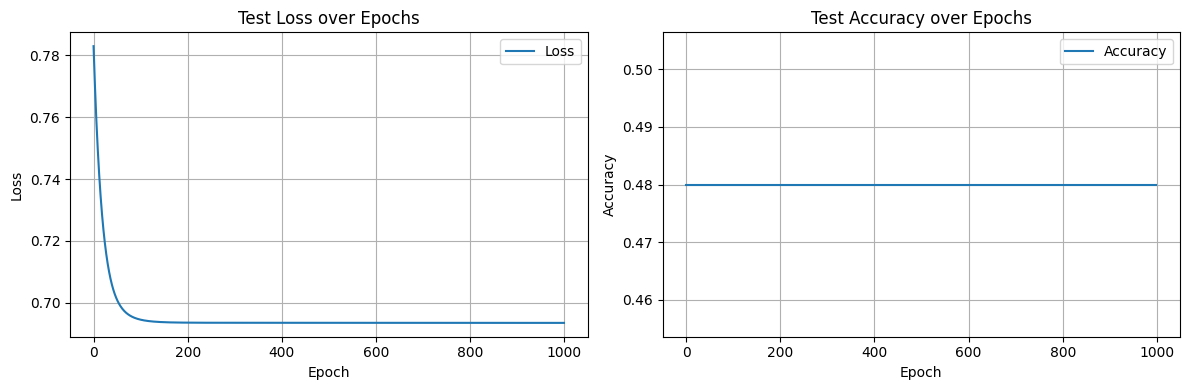

In [ ]:
# Training loop
model = DeepTanhMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
losses, accuracies = train_model(model, X_train, y_train, criterion, optimizer, epochs=1000)
plot_losses_accuracies(losses, accuracies)

Test Accuracy: 100.00%


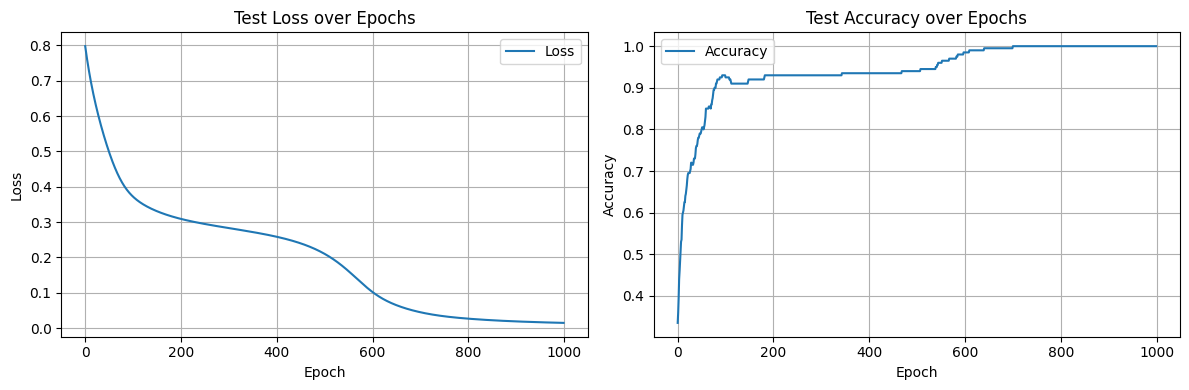

In [ ]:
# Training loop
model_with_initialization = DeepTanhMLP()
### ORTHOGONAL INITIALIZATION
model_with_initialization.apply(init_weights_orthogonal)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_initialization.parameters(), lr=0.03)
losses, accuracies = train_model(model_with_initialization, X_train, y_train, criterion, optimizer, epochs=1000)
plot_losses_accuracies(losses, accuracies)

In [ ]:
# Visualize the effect of each layer
a = torch.arange(-3,3,.5)
b = torch.arange(-3,3,.5)
aa, bb = torch.meshgrid(a, b, indexing='ij')

cartesian_torch = torch.stack([aa.ravel(), bb.ravel()], dim=1)

depth = 8
fleuret_plots = []
with torch.no_grad():
    depths = np.arange(1, 9, 1)
    for my_depth in depths:
        fleuret_plots.append((model.transform(X_test, my_depth),
                              model.transform(cartesian_torch, my_depth)))

fleuret_plots_orthogonal = []
with torch.no_grad():
    depths = np.arange(1, 9, 1)
    for my_depth in depths:
        fleuret_plots_orthogonal.append((model_with_initialization.transform(X_test, my_depth),
                              model_with_initialization.transform(cartesian_torch, my_depth)))


In [ ]:
def plot_layers_effect(plots, X_test, y_test, cartesian_torch):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # Original test set
    ax = axes[0]
    colors = ['red' if y.item() == 0 else 'blue' for y in y_test]
    ax.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='coolwarm', alpha=0.5)
    ax.scatter(cartesian_torch[:,0], cartesian_torch[:,1], marker='+', color='gray', s=30, alpha=0.5)
    ax.set_axis_on()
    ax.set_title("Original")
    ax.axis("equal")
    ax.grid()

    # Intermediate results
    for i, r in enumerate(plots):
        ax = axes[i+1]
        ax.scatter(r[0][:,0], r[0][:,1], c=colors, cmap='coolwarm', alpha=0.5)
        ax.scatter(r[1][:,0], r[1][:,1], marker='+', color='gray', s=30, alpha=0.5)
        ax.set_axis_on()
        ax.set_title(f"After depth {i}")
        ax.axis("equal")
        ax.grid()

    plt.tight_layout()
    plt.show()

/var/folders/pd/5sty4pzx7250bg2vcqz9k4m40000gn/T/ipykernel_36851/3237575911.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='coolwarm', alpha=0.5)
/var/folders/pd/5sty4pzx7250bg2vcqz9k4m40000gn/T/ipykernel_36851/3237575911.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(r[0][:,0], r[0][:,1], c=colors, cmap='coolwarm', alpha=0.5)


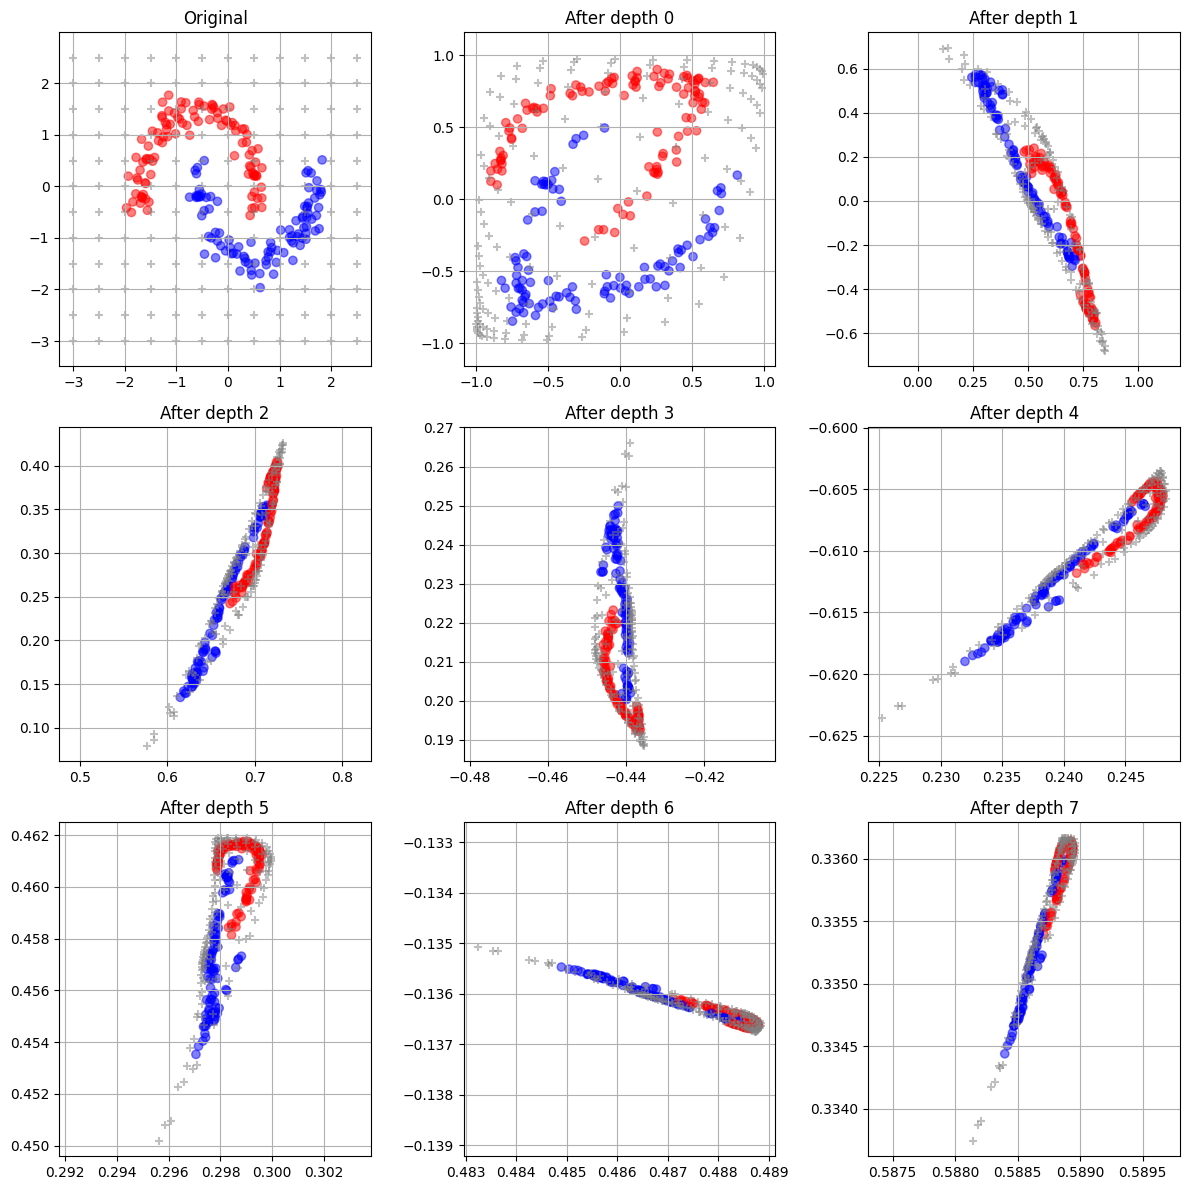

In [ ]:
plot_layers_effect(fleuret_plots, X_test, y_test, cartesian_torch)

# starting from the layer # 1, we see that all the data is squeezed into a single line
# by doing so, we lose information about the data!

/var/folders/pd/5sty4pzx7250bg2vcqz9k4m40000gn/T/ipykernel_36851/3237575911.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='coolwarm', alpha=0.5)
/var/folders/pd/5sty4pzx7250bg2vcqz9k4m40000gn/T/ipykernel_36851/3237575911.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(r[0][:,0], r[0][:,1], c=colors, cmap='coolwarm', alpha=0.5)


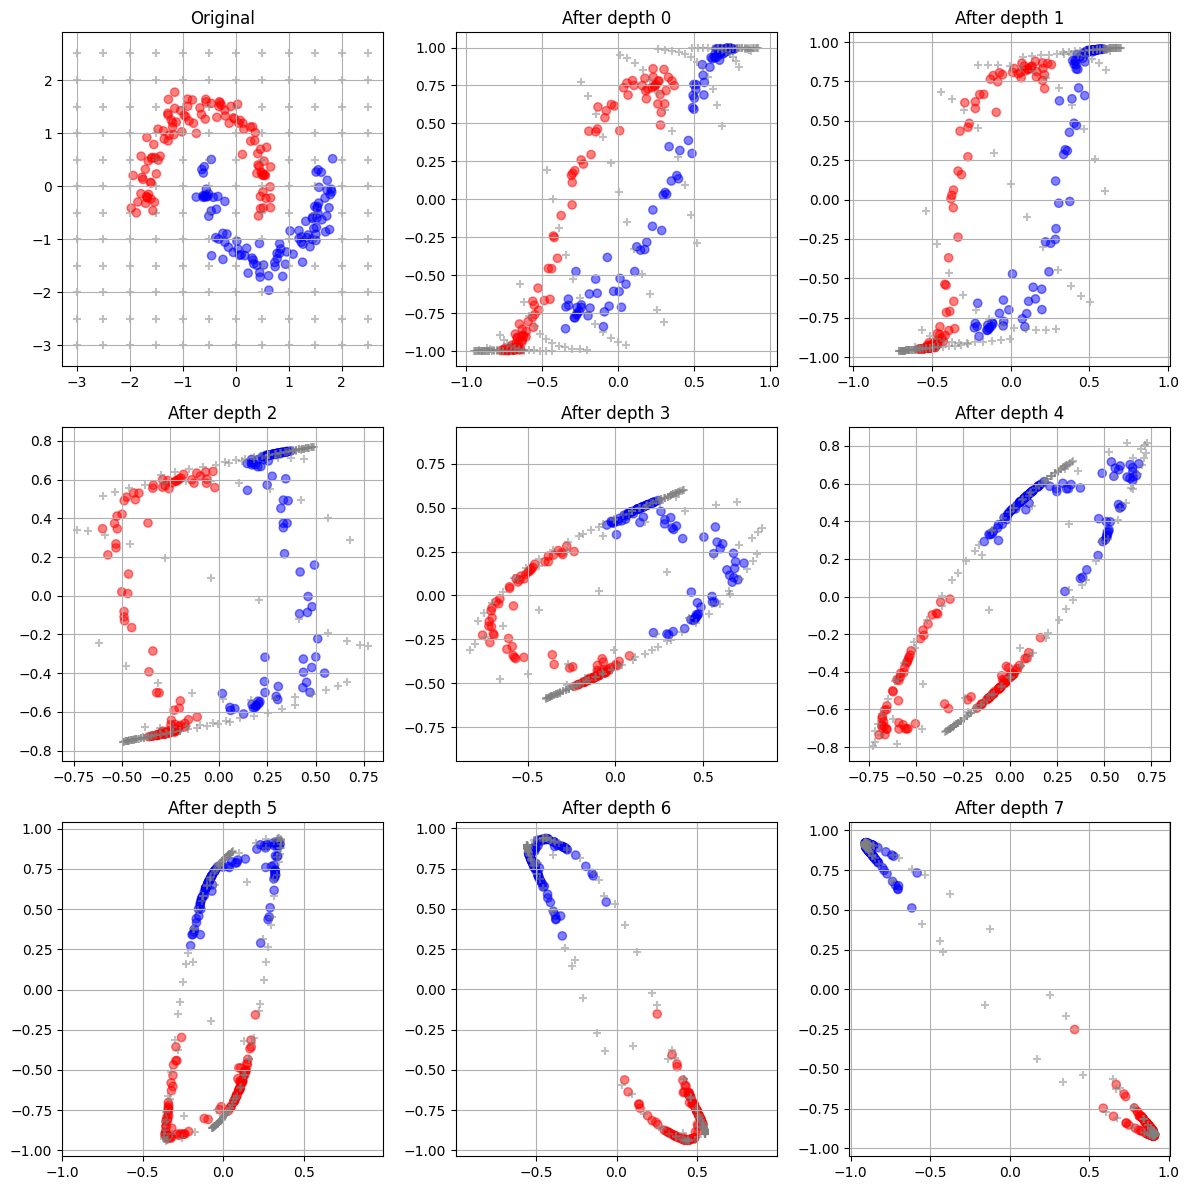

In [ ]:
plot_layers_effect(fleuret_plots_orthogonal, X_test, y_test, cartesian_torch)

# The orthogonal initialization helps to maintain the structure of the data across layers
# and prevents the vanishing gradient problem, allowing for better training of deeper networks.

In [119]:
# If s[1] is very small compared to s[0], then W is nearly rank 1.
print("RANDOM INITIALIZATION")
for x in range(8):
    u, s, v = torch.linalg.svd(model.layers[x].weight.detach())
    print(f"Layer {x} singular values: {s}")

print("\nORTHOGONAL INITIALIZATION")
for x in range(8):
    u, s, v = torch.linalg.svd(model_with_initialization.layers[x].weight.detach())
    print(f"Layer {x} singular values: {s}")

RANDOM INITIALIZATION
Layer 0 singular values: tensor([0.9221, 0.4884])
Layer 1 singular values: tensor([0.9710, 0.0936])
Layer 2 singular values: tensor([0.6273, 0.1235])
Layer 3 singular values: tensor([0.4757, 0.1770])
Layer 4 singular values: tensor([0.7705, 0.2222])
Layer 5 singular values: tensor([0.9553, 0.4274])
Layer 6 singular values: tensor([0.6217, 0.1350])
Layer 7 singular values: tensor([0.7096, 0.5015])

ORTHOGONAL INITIALIZATION
Layer 0 singular values: tensor([1.7645, 0.2109])
Layer 1 singular values: tensor([1.5999, 1.0709])
Layer 2 singular values: tensor([1.4989, 0.8290])
Layer 3 singular values: tensor([1.5814, 0.5803])
Layer 4 singular values: tensor([1.6148, 0.7659])
Layer 5 singular values: tensor([1.6656, 0.8657])
Layer 6 singular values: tensor([1.8517, 0.8446])
Layer 7 singular values: tensor([2.1327, 0.8531])


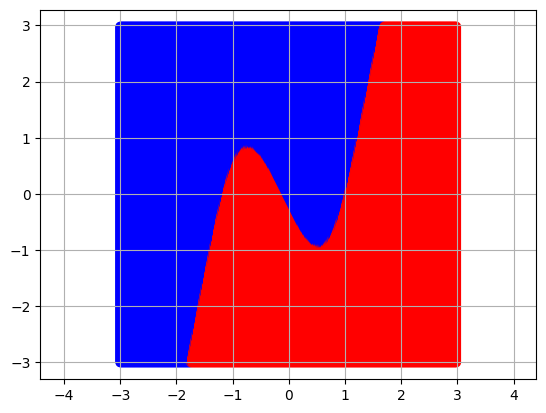

In [79]:
a = torch.arange(-3,3,0.02)
b = torch.arange(-3,3,0.02)
aa, bb = torch.meshgrid(a, b, indexing='ij')

cartesian_torch = torch.stack([aa.ravel(), bb.ravel()], dim=1)

with torch.no_grad():
    logits = model_with_initialization(cartesian_torch)
    probs = torch.sigmoid(logits).squeeze()
    preds = (probs > 0.5).int()

colors = ['red' if y == 0 else 'blue' for y in preds[:, 0]]
plt.scatter(cartesian_torch[:,0], cartesian_torch[:,1], color=colors)
plt.axis("equal")
plt.grid()
